In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# path_to_file = 'merged_files.cpp' # for local
path_to_file = '/content/drive/My Drive/studies/university/AI/merged_files.cpp' # for colab
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 4870656 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])


int main() {
    srand(time(NULL));
    test();
    assert(!ANY_FAILED);
    return 0;
}
bool ANY_FAILED = false;

template <class T>
void assert_equal(T expected, T actual, bool kill = false) {
    if (!(expected == actual)) {
        ANY_FAILED = 


In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

96 unique characters


# Work with input

## Vectorize the text

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '$' :   5,
  '%' :   6,
  '&' :   7,
  "'" :   8,
  '(' :   9,
  ')' :  10,
  '*' :  11,
  '+' :  12,
  ',' :  13,
  '-' :  14,
  '.' :  15,
  '/' :  16,
  '0' :  17,
  '1' :  18,
  '2' :  19,
  ...
}


In [8]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'\nint main() {' ---- characters mapped to int ---- > [ 0 74 79 85  1 78 66 74 79  9 10  1 92]


## Train test split

In [0]:
idx = int(len(text_as_int)*0.75)
train_text_as_int = text_as_int[:idx]
test_text_as_int = text_as_int[idx:]

## To sequences

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100

# Create training examples / targets
train_char_dataset = tf.data.Dataset.from_tensor_slices(train_text_as_int)
test_char_dataset = tf.data.Dataset.from_tensor_slices(test_text_as_int)

In [11]:
train_sequences = train_char_dataset.batch(seq_length+1, drop_remainder=True)
test_sequences = test_char_dataset.batch(seq_length+1, drop_remainder=True)

for item in train_sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'\nint main() {\n    srand(time(NULL));\n    test();\n    assert(!ANY_FAILED);\n    return 0;\n}\nbool ANY_FA'
'ILED = false;\n\ntemplate <class T>\nvoid assert_equal(T expected, T actual, bool kill = false) {\n    if'
' (!(expected == actual)) {\n        ANY_FAILED = true;\n        cout << "Assertion failed:" << endl;\n  '
'      cout << "Expected: " << expected << endl;\n        cout << "  Actual: " << actual << endl;\n     '
'   if (kill) assert(false);\n    }\n}\n\ntemplate <class T>\nvoid assert_not_equal(T not_expected, T actua'


## Create <example, target>

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

train_dataset = train_sequences.map(split_input_target)
test_dataset = test_sequences.map(split_input_target)

In [13]:
for input_example, target_example in  train_dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '\nint main() {\n    srand(time(NULL));\n    test();\n    assert(!ANY_FAILED);\n    return 0;\n}\nbool ANY_F'
Target data: 'int main() {\n    srand(time(NULL));\n    test();\n    assert(!ANY_FAILED);\n    return 0;\n}\nbool ANY_FA'


## Pack into batches

In [14]:
BATCH_SIZE = 64

BUFFER_SIZE = 10000

train = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

train

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Models

In [0]:

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [0]:
def one_layer_gru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


def one_layer_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


def two_layer_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model


def simple_rnn(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.SimpleRNN(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [0]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

EPOCHS=10


## Set a checkpoints

In [0]:

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_gru = f'{checkpoint_dir}/gru'
checkpoint_one_lstm = f'{checkpoint_dir}/one_lstm'
checkpoint_two_lstm = f'{checkpoint_dir}/two_lstm'
checkpoint_simple_rnn = f'{checkpoint_dir}/simple_rnn'

checkpoint_prefix_gru = os.path.join(checkpoint_gru, "ckpt_{epoch}")
checkpoint_prefix_one_lstm = os.path.join(checkpoint_one_lstm, "ckpt_{epoch}")
checkpoint_prefix_two_lstm = os.path.join(checkpoint_two_lstm, "ckpt_{epoch}")
checkpoint_prefix_simple_rnn = os.path.join(checkpoint_simple_rnn, "ckpt_{epoch}")

checkpoint_callback_gru=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_gru,
    save_weights_only=True)

checkpoint_callback_one_lstm=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_one_lstm,
    save_weights_only=True)

checkpoint_callback_two_lstm=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_two_lstm,
    save_weights_only=True)

checkpoint_callback_simple_rnn=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_simple_rnn,
    save_weights_only=True)

## One layer GRU fit

In [0]:
model_gru = one_layer_gru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [20]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24576     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 96)            98400     
Total params: 4,061,280
Trainable params: 4,061,280
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_gru.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [22]:
history_gru = model_gru.fit(train, epochs=EPOCHS, callbacks=[checkpoint_callback_gru], validation_data=test)

Epoch 1/10
565/565 [==============================] - 29s 51ms/step - loss: 1.8167 - accuracy: 0.5775 - val_loss: 1.2465 - val_accuracy: 0.6875
Epoch 2/10
565/565 [==============================] - 28s 50ms/step - loss: 1.0073 - accuracy: 0.7393 - val_loss: 0.9806 - val_accuracy: 0.7509
Epoch 3/10
565/565 [==============================] - 28s 50ms/step - loss: 0.8576 - accuracy: 0.7737 - val_loss: 0.9017 - val_accuracy: 0.7712
Epoch 4/10
565/565 [==============================] - 28s 50ms/step - loss: 0.7777 - accuracy: 0.7924 - val_loss: 0.8649 - val_accuracy: 0.7788
Epoch 5/10
565/565 [==============================] - 28s 50ms/step - loss: 0.7234 - accuracy: 0.8057 - val_loss: 0.8514 - val_accuracy: 0.7842
Epoch 6/10
565/565 [==============================] - 28s 50ms/step - loss: 0.6816 - accuracy: 0.8160 - val_loss: 0.8446 - val_accuracy: 0.7876
Epoch 7/10
565/565 [==============================] - 28s 50ms/step - loss: 0.6483 - accuracy: 0.8246 - val_loss: 0.8434 - val_accuracy:

## One layer LSTM fit

In [0]:
model_one_lstm = one_layer_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [24]:
model_one_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           24576     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense_1 (Dense)              (64, None, 96)            98400     
Total params: 5,369,952
Trainable params: 5,369,952
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_one_lstm.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [26]:
history_one_lstm = model_one_lstm.fit(train, epochs=EPOCHS, callbacks=[checkpoint_callback_one_lstm], validation_data=test)

Epoch 1/10
565/565 [==============================] - 36s 64ms/step - loss: 1.6739 - accuracy: 0.5960 - val_loss: 1.1601 - val_accuracy: 0.7102
Epoch 2/10
565/565 [==============================] - 36s 63ms/step - loss: 0.9649 - accuracy: 0.7486 - val_loss: 0.9502 - val_accuracy: 0.7568
Epoch 3/10
565/565 [==============================] - 36s 63ms/step - loss: 0.8255 - accuracy: 0.7805 - val_loss: 0.8750 - val_accuracy: 0.7747
Epoch 4/10
565/565 [==============================] - 36s 63ms/step - loss: 0.7474 - accuracy: 0.7992 - val_loss: 0.8394 - val_accuracy: 0.7843
Epoch 5/10
565/565 [==============================] - 36s 63ms/step - loss: 0.6925 - accuracy: 0.8128 - val_loss: 0.8212 - val_accuracy: 0.7904
Epoch 6/10
565/565 [==============================] - 36s 63ms/step - loss: 0.6502 - accuracy: 0.8237 - val_loss: 0.8143 - val_accuracy: 0.7934
Epoch 7/10
565/565 [==============================] - 36s 64ms/step - loss: 0.6151 - accuracy: 0.8330 - val_loss: 0.8113 - val_accuracy:

## Two layer LSTM fit

In [0]:
model_two_lstm = two_layer_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [28]:
model_two_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           24576     
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          8392704   
_________________________________________________________________
dense_2 (Dense)              (64, None, 96)            98400     
Total params: 13,762,656
Trainable params: 13,762,656
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_two_lstm.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [30]:
history_two_lstm = model_two_lstm.fit(train, epochs=EPOCHS, callbacks=[checkpoint_callback_two_lstm], validation_data=test)

Epoch 1/10
565/565 [==============================] - 74s 132ms/step - loss: 1.7162 - accuracy: 0.5823 - val_loss: 1.1009 - val_accuracy: 0.7238
Epoch 2/10
565/565 [==============================] - 74s 131ms/step - loss: 0.9279 - accuracy: 0.7565 - val_loss: 0.9096 - val_accuracy: 0.7672
Epoch 3/10
565/565 [==============================] - 74s 131ms/step - loss: 0.7885 - accuracy: 0.7890 - val_loss: 0.8408 - val_accuracy: 0.7814
Epoch 4/10
565/565 [==============================] - 74s 131ms/step - loss: 0.7085 - accuracy: 0.8083 - val_loss: 0.8149 - val_accuracy: 0.7907
Epoch 5/10
565/565 [==============================] - 74s 131ms/step - loss: 0.6499 - accuracy: 0.8227 - val_loss: 0.8059 - val_accuracy: 0.7939
Epoch 6/10
565/565 [==============================] - 74s 131ms/step - loss: 0.6024 - accuracy: 0.8351 - val_loss: 0.8009 - val_accuracy: 0.7974
Epoch 7/10
565/565 [==============================] - 74s 131ms/step - loss: 0.5618 - accuracy: 0.8456 - val_loss: 0.8029 - val_ac

## Simple RNN fit

In [0]:
model_rnn = simple_rnn(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [32]:
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (64, None, 256)           24576     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense_3 (Dense)              (64, None, 96)            98400     
Total params: 1,434,720
Trainable params: 1,434,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_rnn.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [34]:
history_rnn = model_rnn.fit(train, epochs=EPOCHS, callbacks = [checkpoint_callback_simple_rnn], validation_data=test)

Epoch 1/10
565/565 [==============================] - 31s 55ms/step - loss: 1.7547 - accuracy: 0.5803 - val_loss: 1.4708 - val_accuracy: 0.6366
Epoch 2/10
565/565 [==============================] - 31s 55ms/step - loss: 1.1586 - accuracy: 0.7058 - val_loss: 1.1834 - val_accuracy: 0.7052
Epoch 3/10
565/565 [==============================] - 31s 54ms/step - loss: 1.0201 - accuracy: 0.7364 - val_loss: 1.0660 - val_accuracy: 0.7325
Epoch 4/10
565/565 [==============================] - 30s 53ms/step - loss: 0.9512 - accuracy: 0.7517 - val_loss: 1.0104 - val_accuracy: 0.7459
Epoch 5/10
565/565 [==============================] - 30s 54ms/step - loss: 0.9063 - accuracy: 0.7621 - val_loss: 0.9984 - val_accuracy: 0.7514
Epoch 6/10
565/565 [==============================] - 30s 53ms/step - loss: 0.8739 - accuracy: 0.7691 - val_loss: 0.9792 - val_accuracy: 0.7535
Epoch 7/10
565/565 [==============================] - 30s 53ms/step - loss: 0.8497 - accuracy: 0.7748 - val_loss: 0.9592 - val_accuracy:


# Generate text

In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 500

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [0]:
# GRU
model_gru = one_layer_gru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=1)

model_gru.load_weights(tf.train.latest_checkpoint(checkpoint_gru))

model_gru.build(tf.TensorShape([1, None]))


# One layer LSTM
model_one_lstm = one_layer_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=1)

model_one_lstm.load_weights(tf.train.latest_checkpoint(checkpoint_one_lstm))

model_one_lstm.build(tf.TensorShape([1, None]))


# Two layers LSTM
model_two_lstm = two_layer_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=1)

model_two_lstm.load_weights(tf.train.latest_checkpoint(checkpoint_two_lstm))

model_two_lstm.build(tf.TensorShape([1, None]))


# Simple RNN
model_rnn = simple_rnn(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=1)

model_rnn.load_weights(tf.train.latest_checkpoint(checkpoint_simple_rnn))

model_rnn.build(tf.TensorShape([1, None]))

## GRU

In [61]:
print(generate_text(model_gru, start_string="int main() {"))

int main() {
 ;

        int pos2 = 0;

        for(int i = 1;i < m;++i) no_to[i] = cont[i + 1] ];
    }
}

int main(){
    int T,l,r;

    ount(n,cont 0));
        aux.A[0]=0;
        for(int i=k-1;i>=0;i--)
        if(!visited[aux.b][i]) return aux.time;
    }
    for (int i: adj[x]) if 1

using namespace std;

vector<int> L[100005];
int ani[9][93817];

int primo[38][28],memo[98][m1][C2][(1 << 55)];

int score(char c){
    if(c>=0 && b-'-6<<r) return I>     int m = cost[ (ad        val_rest_label[0] = {0,


## One layer LSTM

In [62]:
print(generate_text(model_one_lstm, start_string="int main() {"))

int main() {

    setIO("prrome");
    re(N,M); re(C);

         return 0;
}
#include<iostream>
#include<bitset>
#include<algorithm>
#include <vector>
#include <string>
#include <map>

using namespace std;

int main(){
    int C,N,a[10000],ans = 0,cur = N;
    dp[0] = 1;
    for(int i = 0;i < N;++i) return 0;
}
#include <cstdio>
#include <cstring>

using namespace std;

#define MOD 1000000000000

int Q[4 * MAXN];
vector< vector<int> > L;
dequery(int l, int r) {
    adj[u].pb(v); }
  poly[v].insert(par[cur] 


## Two layers LSTM

In [63]:
print(generate_text(model_two_lstm, start_string="int main() {"))

int main() { E.rollink; int BIMXN][MAX_N], c[MAXN], p[MAXN], W[MAXLEN],l[MAXE], next[E] = last[v]; last[v] = E++;
    }

    bit[v] = k;

       for(int i = 0,a,b,p;i<T;++i){
            scanf("%d",&m);
            add_edge(a,b);
        }

        f++;
    }

    return integrour=p[ans_Arg]>
        inv = randint(0, n-1);
        assert(sz(v) == 3);
        int v = rand() % 3;

        if (s[0] != M) {
            trav(a,sz(b)) add[b] = merge(abs, b.get(R));
            }
            svoid query(long long 


## Simple RNN

In [64]:
print(generate_text(model_rnn, start_string="int main() {"))

int main() {

    seq[pos] = 1 + M[cur].size();

    for(int i = 1;i < m;++i) cin>>x;

        if(dp[0]=true;

        int best = 0;

        while(lo < hi){
            int mi = (checkr[i] && dist[i][j] != 0 ? a[i] : Ring[0].f), b[i] -= a;
     R(C).sont(a.f+B)%alld.ragre       if (c == 'W' && cur % p1 && valid(-1,-1)) ++t[c] += a[i * N + dc[cur],min(pos[ind]), l->itINF(A,s);
  return newn = P.size();
 la nt = 0; x <<=N;
++i) n /= 3;
   else cur = Q[head]; g2=XC;
    else return min(l + t) / 2 < n * b;
 }



# Visualize Metrics

In [0]:
def draw_metric(history, metric, name):
  # Get training and test loss histories
  training_loss = history.history[metric]
  test_loss = history.history['val_' + metric]

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training '+metric, 'Test '+metric])
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  # plt.show()
  plt.savefig(f'/content/drive/My Drive/studies/university/AI/img/{name}_{metric}.png')


### GRU

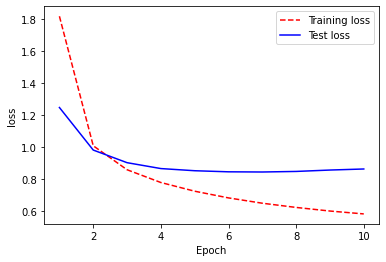

In [52]:
draw_metric(history_gru, 'loss', 'gru')

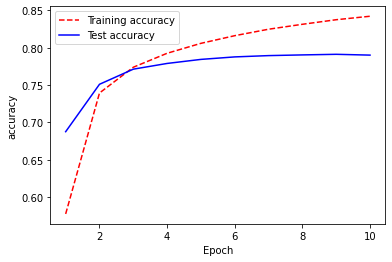

In [53]:
draw_metric(history_gru, 'accuracy', 'gru')

### One layer LSTM

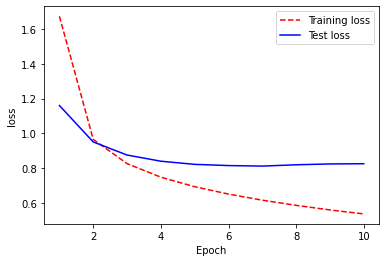

In [54]:
draw_metric(history_one_lstm, 'loss', 'one_lstm')

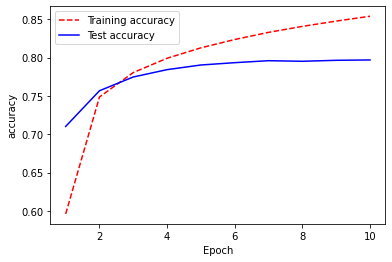

In [55]:
draw_metric(history_one_lstm, 'accuracy', 'one_lstm')

### Two layer LSTM

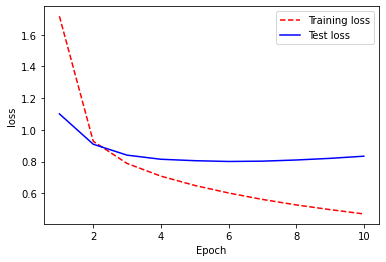

In [56]:
draw_metric(history_two_lstm, 'loss', 'two_lstm')

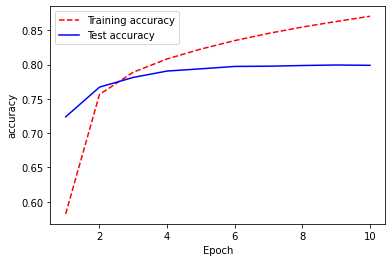

In [57]:
draw_metric(history_two_lstm, 'accuracy', 'two_lstm')

### Simple RNN

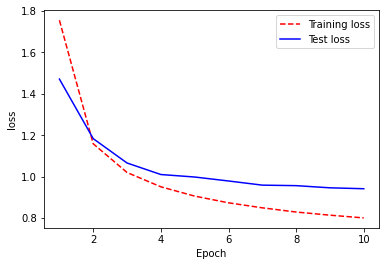

In [58]:
draw_metric(history_rnn, 'loss', 'rnn')

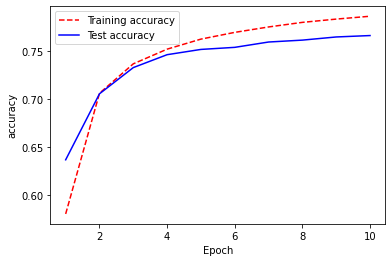

In [59]:
draw_metric(history_rnn, 'accuracy', 'rnn')